In [1243]:
## Import dependencies
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas_ta as ta
import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
import warnings
warnings.filterwarnings('ignore')
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from backtesting import set_bokeh_output
backtesting.set_bokeh_output(notebook=False)
from backtesting.lib import resample_apply
from backtesting.lib import crossover, TrailingStrategy


In [1244]:
## Manually inserted variables
symbol = 'NG=F'
tod = datetime.now()
d = timedelta(days = 729)
a = tod - d

start_date = a
end_date = tod

In [1245]:
## Import Data and create Heiken Ashi for the execution timeframe
df = yf.download(symbol, start=start_date, end=end_date, interval='60m')
df = df.tz_localize(None)
df.reset_index(inplace=True)
del df['Adj Close']
df['c'] = (((df['Open'] + df['High'] + df['Low'] + df['Close'])) / 4)
df['o'] = df['Open']
df['o'] = ((df['o'].shift(1) + df['c'].shift(1)) / 2)
df['h'] = df[['High', 'o', 'c']].max(axis=1)
df['l'] = df[['Low', 'o', 'c']].min(axis=1)
df['state'] = np.where(df.c > df.o,1,-1)
df['state'] = df['state'].shift(1)
df = df[['Datetime', 'Open', 'High', 'Low','Close','Volume', 'state']]
df['atr'] = (df.High.rolling(100).sum() - df.Low.rolling(100).sum()) / 100
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [1246]:
## Import Data and create Heiken Ashi for the daily timeframe
tod = datetime.now()
d = timedelta(days = 2000)
a = tod - d
start_date = a
end_date = tod
df_d = yf.download(symbol, start=start_date, end=end_date, interval='1d')
df_d = df_d.tz_localize(None)
df_d.reset_index(inplace=True)
df_d.rename(columns = {'Date': 'Datetime'}, inplace = True) 
df_d.set_index('Datetime', inplace=True)
#Heiken Ashi Calculation
df_d['c'] = (((df_d['Open'] + df_d['High'] + df_d['Low'] + df_d['Close'])) / 4)
df_d['o'] = df_d['Open']
for i in range(1, len(df_d)):
    df_d['o'][i] = ((df_d['o'][i-1]+df_d['c'][i-1])/2)
df_d['dhigh'] = df_d[['High', 'o', 'c']].max(axis=1)
df_d['dlow'] = df_d[['Low', 'o', 'c']].min(axis=1)
# State Calcutation
df_d['dstate'] = np.where(df_d.c > df_d.o, 1,-1)
df_d['dstate'] = df_d['dstate'].shift(1)
# Resampling
df_d = df_d.resample('60Min', label='right').last()
df_d.fillna(method='ffill', inplace=True)
# Only relevant data
df_d = df_d[['dstate','dhigh','dlow']]
df_d.dropna(inplace=True)
df_d.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [1247]:
## Import Data and create Heiken Ashi for the weekly timeframe
df_w = yf.download(symbol, start="2002-01-01", end=end_date, interval='1wk')
df_w = df_w.tz_localize(None)
df_w.reset_index(inplace=True)
df_w.rename(columns = {'Date': 'Datetime'}, inplace = True) 
df_w.set_index('Datetime', inplace=True)
#Heiken Ashi Calculation
df_w['c'] = ((df_w['Open'] + df_w['High'] + df_w['Low'] + df_w['Close'])) / 4
df_w['o'] = df_w['Open']
for i in range(1, len(df_w)):
    df_w['o'][i] = ((df_w['o'][i-1]+df_w['c'][i-1])/2)
df_w['whigh'] = df_w[['High', 'o', 'c']].max(axis=1)
df_w['wlow'] = df_w[['Low', 'o', 'c']].min(axis=1)
df_w['wstate'] = np.where(df_w.c > df_w.o, 1,-1)
df_w['wstate'] = df_w['wstate'].shift(1)
# Resampling to 240m data
df_w = df_w.resample('60Min', label='right').last()
df_w.fillna(method='ffill', inplace=True)
# Only relevant data
df_w = df_w[['wstate', 'whigh','wlow']]
df_w.dropna(inplace=True)
df_w.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [1248]:
#Merge Data
df = pd.merge(df, df_d, on="Datetime")
df = pd.merge(df, df_w, on="Datetime")
df.dropna(inplace=True)


df.set_index('Datetime', inplace=True)
df['HE_CET'] = [x.hour for x in df.index]
df['istradingallowed'] = [ 1 if x > 7 and x < 20 else 0 for x in df['HE_CET']]
df.reset_index(inplace=True)
df

,Datetime,Open,High,Low,Close,Volume,state,atr,dstate,dhigh,dlow,wstate,whigh,wlow,HE_CET,istradingallowed
0,2021-04-01 00:00:00,2.602,2.603,2.594,2.596,326,1.0,0.01458,1.0,2.656000,2.575,-1.0,2.68800,2.530,0,0
1,2021-04-01 01:00:00,2.596,2.597,2.590,2.590,442,-1.0,0.01454,1.0,2.663000,2.578,-1.0,2.68800,2.530,1,0
2,2021-04-01 02:00:00,2.590,2.598,2.580,2.598,1148,-1.0,0.01467,1.0,2.663000,2.578,-1.0,2.68800,2.530,2,0
3,2021-04-01 03:00:00,2.599,2.611,2.594,2.607,1105,-1.0,0.01473,1.0,2.663000,2.578,-1.0,2.68800,2.530,3,0
4,2021-04-01 04:00:00,2.607,2.610,2.603,2.608,502,1.0,0.01457,1.0,2.663000,2.578,-1.0,2.68800,2.530,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11276,2023-03-23 21:00:00,2.162,2.163,2.157,2.161,297,1.0,0.03262,-1.0,2.285603,2.136,-1.0,2.53523,2.127,21,0
11277,2023-03-23 22:00:00,2.159,2.165,2.159,2.163,114,1.0,0.03232,-1.0,2.285603,2.136,-1.0,2.53523,2.127,22,0
11278,2023-03-23 23:00:00,2.164,2.181,2.163,2.174,308,1.0,0.03201,-1.0,2.285603,2.136,-1.0,2.53523,2.127,23,0
11279,2023-03-24 00:00:00,2.177,2.177,2.171,2.175,63,1.0,0.03191,-1.0,2.285603,2.136,-1.0,2.53523,2.127,0,0


In [1249]:


#Define trading rules
df['buysignal'] = np.where((((df.state.shift(1) < 0) & (df.dstate > 0)) & (df.state > 0) & (df.wstate > 0)), 1, 0)
df['sellsignal'] = np.where((((df.state.shift(1) > 0)  & (df.dstate < 0)) & (df.state < 0) & (df.wstate < 0)), 1, 0)

In [1250]:
class LT(Strategy):


    target = 2
    stop = 1
    
    
    def init(self):
        # Compute moving averages the strategy demands
        self.state = self.I(SMA, self.data.state, 1)
        self.dstate = self.I(SMA, self.data.dstate,1)
        self.wstate = self.I(SMA, self.data.wstate,1)
        self.atr = self.I(SMA, self.data.atr,1)
        # self.wstate = self.I(SMA, self.data.wstate,1)
        # self.whigh = self.I(SMA, self.data.whigh, 1)
        # self.wlow = self.I(SMA, self.data.wlow, 1)
        # self.dhigh = self.I(SMA, self.data.dhigh, 1)
        # self.dlow = self.I(SMA, self.data.dlow, 1)

        # Compute stoploss as a function 
        # self.stoplossfunction = self.I(Rsi, stop / 10 
        # self.targetfunction = target / 10
        
        # # Compute daily RSI(30)
        # self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # # To construct weekly RSI, we can use `resample_apply()`
        # # helper function from the library
        # self.weekly_rsi = resample_apply(
        #     'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        buysignal = self.data.buysignal[-1]
        sellsignal = self.data.sellsignal[-1]                
        pricenow = self.data.Close[-1]
        highnow = self.data.High[-1]
        lownow = self.data.Low[-1]        
        dhigh = self.data.dhigh[-1]
        dlow = self.data.dlow[-1]
        whigh = self.data.whigh[-1]
        wlow = self.data.wlow[-1]


        # Long Positions
        if (buysignal > 0) & (self.position.size < 40001):
                    entry = self.data.Close[-1]
                    self.buy(size = 10000, sl = entry - 0.1, tp = entry + 0.2)

        # ## Short positions
        if (sellsignal > 0) & (self.position.size > -40001):
                    entry = self.data.Close[-1]
                    self.sell(size = 10000, sl = entry + 0.1, tp = entry - 0.2)
                    




In [1251]:
bt = Backtest(df, LT, cash=100000, commission=0.001 , trade_on_close=True)
bt.run()

Start                                     0.0
End                                   11280.0
Duration                              11280.0
Exposure Time [%]                   58.310433
Equity Final [$]                  240231.5659
Equity Peak [$]                  242643.95514
Return [%]                         140.231566
Buy & Hold Return [%]              -16.756547
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -28.801469
Avg. Drawdown [%]                   -1.579901
Max. Drawdown Duration                 2429.0
Avg. Drawdown Duration              80.985294
# Trades                                760.0
Win Rate [%]                        41.052632
Best Trade [%]                       9.910667
Worst Trade [%]                     -5.100105
Avg. Trade [%]                    

In [1252]:
bt.plot()

Row(id='112244', ...)

In [1253]:
stats = bt.run()
stats['_trades']
df = stats['_trades']
df['cents'] = np.where((df['Size'] > 0), (df['ExitPrice'] - df['EntryPrice']), (df['EntryPrice'] - df['ExitPrice']))
df['R'] = np.where(df.cents > 0, 2,-1)
df


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,cents,R
0,10000,37,250,2.513511,2.711,1974.890001,0.078571,37,250,213,0.197489,2
1,10000,256,421,2.721719,2.919,1972.809999,0.072484,256,421,165,0.197281,2
2,10000,254,421,2.720718,2.918,1972.820001,0.072511,254,421,167,0.197282,2
3,10000,259,427,2.735733,2.933,1972.670000,0.072108,259,427,168,0.197267,2
4,10000,440,710,2.909907,3.107,1970.929999,0.067732,440,710,270,0.197093,2
...,...,...,...,...,...,...,...,...,...,...,...,...
755,-10000,11252,11279,2.191806,2.175,168.060534,0.007668,11252,11279,27,0.016806,2
756,-10000,11244,11279,2.252745,2.175,777.451620,0.034511,11244,11279,35,0.077745,2
757,-10000,11235,11279,2.292705,2.175,1177.051239,0.051339,11235,11279,44,0.117705,2
758,-10000,11229,11279,2.296701,2.175,1217.010725,0.052990,11229,11279,50,0.121701,2


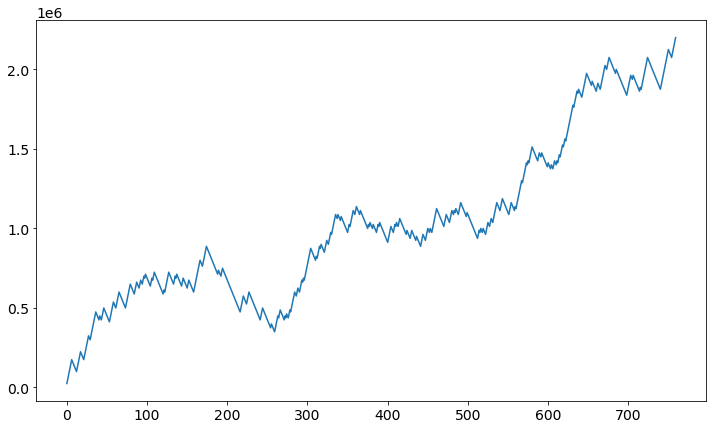

In [1254]:
plt.plot(df.R.cumsum()*12500)

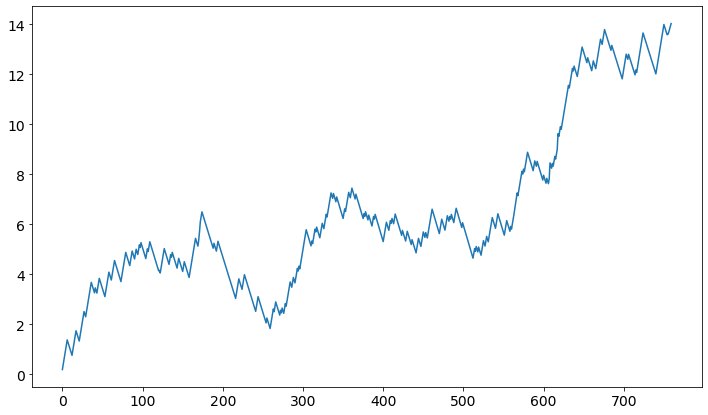

In [1255]:
plt.plot(df.cents.cumsum())

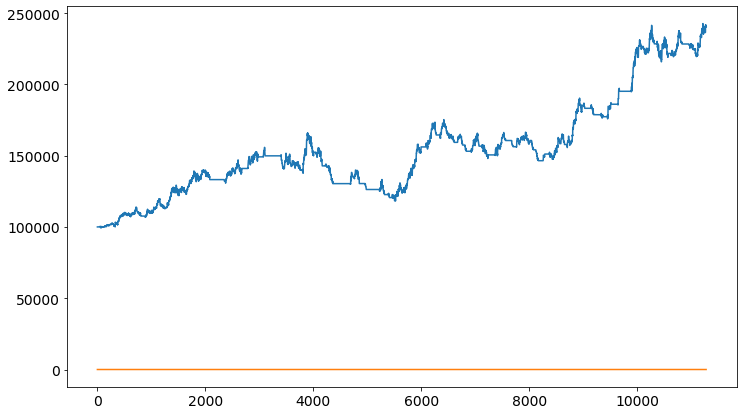

In [1256]:
ax = plt.plot(stats['_equity_curve'])
